In [526]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [355]:
df = pd.read_csv('subscribers-updated.csv')
df = df.drop(['Unnamed: 0'], axis=1,)
df

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,...,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,...,NaN,ar,Standard Charter,14,True,1,7/2/2020 21:44,7/6/2020 21:44,NaN,True
1,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,UAE,...,0.3303,ar,NaN,14,True,1,15/3/2020 15:44,15/7/2020 15:44,NaN,True
2,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,UAE,...,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,UAE,...,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,UAE,...,0.0367,ar,NaN,14,True,2,19/2/2020 12:57,19/6/2020 12:57,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227623,21434712,enhanced,3.0,comedy,supplement OTT,28.751405,2.0,38.0,False,UAE,...,0.3303,ar,NaN,14,True,1,1/12/2019 14:12,1/4/2020 14:12,NaN,True
227624,25843074,enhanced,2.0,comedy,replace OTT,27.301448,2.0,49.0,False,UAE,...,0.3303,ar,Paypal,14,True,1,20/12/2019 18:02,20/4/2020 18:02,NaN,True
227625,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,45.0,False,UAE,...,0.0367,ar,NaN,14,True,1,4/1/2020 19:40,4/5/2020 19:40,NaN,True
227626,21308040,base,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,...,NaN,ar,Paypal,14,True,1,31/1/2020 23:58,31/5/2020 23:58,NaN,True


# Data Cleaning 

In [ ]:
# Dealing with abnormal value

In [356]:
for n in range(0,len(df)):
    if df.loc[n,'age'] > 2018:
        df.loc[n,'age'] = None
    elif df.loc[n,'age'] > 1929:
        df.loc[n,'age'] = 2019 - df.loc[n,'age']
    elif df.loc[n,'age'] > 108:
        df.loc[n,'age'] = None

In [357]:
# drop negative value:
df=df[df['age']>0]
df=df[df['weekly_consumption_hour']>0]
df=df[df['num_ideal_streaming_services']>0]

In [358]:
numweek = df.num_weekly_services_utilized.mean()
numideal = df.num_ideal_streaming_services.mean()
df['num_weekly_services_utilized'].fillna(numweek,inplace=True)
df['num_ideal_streaming_services'].fillna(numideal,inplace=True)

In [573]:
df.to_csv('cleaneddata.csv')

## Create x-value form 

In [424]:
churn = df[['subid', 'package_type', 'num_weekly_services_utilized',
       'preferred_genre', 'intended_use', 'weekly_consumption_hour',
        'num_ideal_streaming_services','age', 'male_TF','attribution_technical',
        'op_sys','join_fee','plan_type','payment_period','account_creation_date','cancel_date']]

churn['account_creation_date'] = pd.to_datetime(churn['account_creation_date'])

<ipython-input-424-c76e68d5ad22>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['account_creation_date'] = pd.to_datetime(churn['account_creation_date'])


In [425]:
churn =  churn[churn['plan_type']=='base_uae_14_day_trial']
#churn.info()

In [426]:
churn.dropna(subset=['package_type','preferred_genre'],inplace=True)
churn = churn.reset_index()
churn.drop('index',axis='columns', inplace=True)

In [427]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92823 entries, 0 to 92822
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   subid                         92823 non-null  int64         
 1   package_type                  92823 non-null  object        
 2   num_weekly_services_utilized  92823 non-null  float64       
 3   preferred_genre               92823 non-null  object        
 4   intended_use                  92662 non-null  object        
 5   weekly_consumption_hour       92823 non-null  float64       
 6   num_ideal_streaming_services  92823 non-null  float64       
 7   age                           92823 non-null  float64       
 8   male_TF                       92823 non-null  object        
 9   attribution_technical         92823 non-null  object        
 10  op_sys                        92823 non-null  object        
 11  join_fee                    

## 1. Create user churn Y = 1, p = 0

In [428]:
churnp0 = churn[churn['payment_period'] == 0]
len(churnp0)

33464

##### 1.1 period_0 + Trial End

In [429]:
trialend1 = churnp0[((churnp0['account_creation_date']<= '2020-03-13 00:00:00') == True)]
trialend2 = churnp0[(churnp0['cancel_date'].isnull() == True)]
trialend = churnp0[((churnp0['account_creation_date']<= '2020-03-13 00:00:00') == True) & (churnp0['cancel_date'].isnull() == True)]
len(trialend)

17080

##### 1.2 period_0 + Active Cancel

In [430]:
actcancel = churnp0[(churnp0['cancel_date'].isnull() == False)]
len(actcancel)

9369

In [431]:
# Combine 
combine = [trialend,actcancel]
churny1 = pd.concat(combine)
len(churn)
churny1['churn'] = 1
churny1

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,attribution_technical,op_sys,join_fee,plan_type,payment_period,account_creation_date,cancel_date,churn
0,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,organic,iOS,0.1101,base_uae_14_day_trial,0,2019-07-12 16:37:00,NaN,1
5,25393847,base,2.0,regional,supplement OTT,28.751405,2.0,57.0,False,brand sem intent google,iOS,0.0367,base_uae_14_day_trial,0,2019-09-28 20:50:00,NaN,1
6,23163827,economy,3.0,comedy,replace OTT,33.101274,2.0,54.0,False,facebook,iOS,0.0367,base_uae_14_day_trial,0,2019-08-16 23:56:00,NaN,1
7,21829221,enhanced,2.0,comedy,replace OTT,27.301448,2.0,24.0,False,google_organic,Android,0.0367,base_uae_14_day_trial,0,2019-10-16 01:16:00,NaN,1
18,23299478,base,2.0,comedy,replace OTT,22.951579,2.0,35.0,False,facebook,iOS,0.0367,base_uae_14_day_trial,0,2019-12-24 17:07:00,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92764,21358316,base,2.0,comedy,replace OTT,27.301448,2.0,24.0,False,search,Android,0.0367,base_uae_14_day_trial,0,2019-10-15 18:33:00,19/10/2019 0:00,1
92767,23379536,enhanced,2.0,comedy,replace OTT,24.401536,2.0,42.0,False,brand sem intent google,Android,0.0367,base_uae_14_day_trial,0,2020-07-03 13:00:00,14/3/2020 0:00,1
92768,23266621,base,2.0,comedy,access to exclusive content,25.851492,2.0,58.0,False,facebook,Android,0.3303,base_uae_14_day_trial,0,2019-04-12 05:45:00,5/12/2019 0:00,1
92792,25341091,enhanced,2.0,drama,replace OTT,24.401536,2.0,59.0,False,pinterest,iOS,0.6606,base_uae_14_day_trial,0,2019-11-26 12:55:00,9/12/2019 0:00,1


## 2. Create user churn Y = 0,  p=1

In [481]:
#nochurn = churn[((churn['payment_period'] > 0) == True)]
churny0 = churn[churn['payment_period'] > 0]
churny0['churn'] = 0
len(churny0)

<ipython-input-481-af42e65e3182>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churny0['churn'] = 0


59359

## 3. Combine Y =1 & Y= 0

In [549]:
combine = [churny1,churny0]
trval =  pd.concat(combine)

trval = trval.reset_index()
trval.drop('index',axis='columns', inplace=True)
#trval

## 4. user-not decided Y = ?, p=0

In [564]:
undecide1 = churnp0[((churnp0['account_creation_date']<= '2020-03-13 00:00:00') == False)]
undecide2 = churnp0[(churnp0['cancel_date'].isnull() == True)]
undecide = churnp0[((churnp0['account_creation_date']<= '2020-03-13 00:00:00') == False) & (churnp0['cancel_date'].isnull() == True)]
undecide

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,attribution_technical,op_sys,join_fee,plan_type,payment_period,account_creation_date,cancel_date
11,26520640,enhanced,2.0,drama,access to exclusive content,24.401536,2.0,37.0,False,facebook,Android,0.6606,base_uae_14_day_trial,0,2020-03-13 10:29:00,NaN
21,20395793,base,2.0,drama,access to exclusive content,20.051667,2.0,25.0,False,affiliate,iOS,0.1101,base_uae_14_day_trial,0,2020-03-22 00:47:00,NaN
37,28758163,enhanced,3.0,drama,access to exclusive content,31.651317,2.0,43.0,False,email,iOS,0.0000,base_uae_14_day_trial,0,2020-03-23 21:37:00,NaN
38,26795774,base,3.0,comedy,supplement OTT,28.751405,2.0,38.0,False,affiliate,Android,0.3303,base_uae_14_day_trial,0,2020-03-25 04:37:00,NaN
73,21188329,base,2.0,comedy,replace OTT,21.501623,2.0,27.0,False,brand sem intent google,iOS,0.0367,base_uae_14_day_trial,0,2020-12-02 19:51:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92775,27830586,economy,5.0,international,access to exclusive content,40.351055,3.0,62.0,True,facebook,Android,0.3303,base_uae_14_day_trial,0,2020-03-19 13:57:00,NaN
92777,25744972,enhanced,4.0,drama,access to exclusive content,24.401536,2.0,31.0,False,google_organic,Android,0.0367,base_uae_14_day_trial,0,2020-03-20 03:12:00,NaN
92794,21227573,base,3.0,drama,supplement OTT,30.201361,2.0,65.0,False,affiliate,Android,0.3303,base_uae_14_day_trial,0,2020-05-03 15:41:00,NaN
92797,22732963,enhanced,4.0,drama,access to exclusive content,30.201361,3.0,50.0,False,email,Android,0.0000,base_uae_14_day_trial,0,2020-03-26 03:29:00,NaN


## Pick x-features & fit model

In [569]:
Xfinal = trval[['package_type', 'num_weekly_services_utilized',
       'preferred_genre', 'intended_use', 'weekly_consumption_hour',
       'num_ideal_streaming_services', 'age', 'male_TF',
       'attribution_technical', 'op_sys', 'join_fee']]
yfinal = trval[['churn']]

#X_un = undecide[['package_type', 'num_weekly_services_utilized',
#       'preferred_genre', 'intended_use', 'weekly_consumption_hour',
#       'num_ideal_streaming_services', 'age', 'male_TF',
#       'attribution_technical', 'op_sys', 'join_fee']]

In [571]:
Xfinal =  pd.get_dummies(Xfinal,drop_first = True)
#X_un =  pd.get_dummies(X_un,drop_first = True)
#X_un.info()
#yfinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7015 entries, 11 to 92808
Data columns (total 44 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   num_weekly_services_utilized                   7015 non-null   float64
 1   weekly_consumption_hour                        7015 non-null   float64
 2   num_ideal_streaming_services                   7015 non-null   float64
 3   age                                            7015 non-null   float64
 4   join_fee                                       7015 non-null   float64
 5   package_type_economy                           7015 non-null   uint8  
 6   package_type_enhanced                          7015 non-null   uint8  
 7   preferred_genre_drama                          7015 non-null   uint8  
 8   preferred_genre_international                  7015 non-null   uint8  
 9   preferred_genre_other                          701

In [541]:
#seperate train-test sets
X_train, X_val, y_train, y_val = train_test_split(Xfinal, yfinal, test_size=0.30, random_state=1997)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60065 entries, 63311 to 36409
Data columns (total 50 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   num_weekly_services_utilized                   60065 non-null  float64
 1   weekly_consumption_hour                        60065 non-null  float64
 2   num_ideal_streaming_services                   60065 non-null  float64
 3   age                                            60065 non-null  float64
 4   join_fee                                       60065 non-null  float64
 5   package_type_economy                           60065 non-null  uint8  
 6   package_type_enhanced                          60065 non-null  uint8  
 7   preferred_genre_drama                          60065 non-null  uint8  
 8   preferred_genre_international                  60065 non-null  uint8  
 9   preferred_genre_other                         

In [567]:
#normalization with minmax
#change from dataframe to array
minmaxscaler = MinMaxScaler()
X_train = minmaxscaler.fit_transform(X_train) 
X_val = minmaxscaler.fit_transform(X_val) 
#X_un = minmaxscaler.fit_transform(X_un) 

In [543]:
# fit a model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred=logreg.predict(X_val)

# predict probabilities
y_pred_prob=logreg.predict_proba(X_val)

# keep probabilities for the positive outcome only
y_pred_prob = y_pred_prob[:, 1]
# from 2-dimension to 1-dimension 
y_valTranf= y_val['churn'].values

/Users/spencerzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/spencerzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [545]:
# auc score
log_auc = roc_auc_score(y_valTranf, y_pred_prob)
log_auc

0.8887958798654251

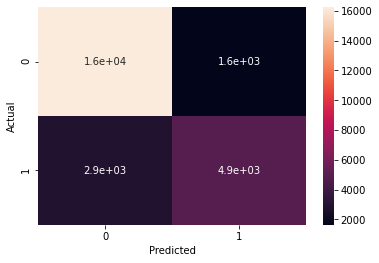

In [546]:
confusion_matrix = pd.crosstab(y_valTranf,y_pred,rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

In [574]:
confusion_matrix

Predicted,0,1
Actual,,
0,16239,1640
1,2924,4940


In [547]:
print('Accuracy: ',metrics.accuracy_score(y_val, y_pred))
plt.show()

Accuracy:  0.8227090859651167


In [576]:
print('Recall: ',metrics.recall_score(y_val, y_pred))
plt.show()

Recall:  0.6281790437436419


In [577]:
print('Precision: ',metrics.precision_score(y_val, y_pred))
plt.show()

Precision:  0.7507598784194529


In [572]:
#y_un=logreg.predict(X_un)